In [68]:
# first let's look at atime alignment precision.

# obvious procedure for raw signals:
# a) sample a wiggle from some prior
# b) sample background noise from some prior
# c) add the two with the wiggle at known offset
# d) compute the envelope of the resulting signal
# e) extract wavelet coefs from the generated signal AND envelope (given true alignment). 
     # we don't even need a GP, can just take the posteriors and add some noise variance to get a prior for
     # the "next" signal
# f) generate a new signal with very similar wavelets and resampled noise
# g) compute xc of the two signals, and the two envelopes. look at width of xc peak. (could even repeat this sampling many times 
     # to get the sampling distribution of the xc peak and estimate error that way)
# f) similarly compute posterior distribution on atime under the wavelet model.
# h) finally compute the signal probability ratio under the wavelet model (in raw signal and in the envelope) to get 
     # the likliehood of event existence. do the same for the XC peak.

# okay, we want to parameterize by 
# a) template params. *particularly* atime and coda_height
# b) length and parameterization of the repeatable wiggle
# c) noise model for the underlying signal

from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.signals.common import Waveform
from sigvisa.signals.io import fetch_waveform

from sigvisa.source.event import get_event
from sigvisa.ssms_c import CompactSupportSSM, TransientCombinedSSM, ARSSM
from sigvisa.models.wiggles.wavelets import construct_wavelet_basis, construct_implicit_basis_C
from sigvisa.models.noise.armodel.model import ARModel, ErrorModel
from sigvisa.models.noise.armodel.learner import ARLearner
from sigvisa.models.templates.lin_polyexp import LinPolyExpTemplateGenerator
import obspy.signal.filter

# Noise Models

In [259]:

wave = fetch_waveform("AS12", "SHZ", 1240995024.6, 1240995424.6+120).filter("freq_0.8_4.5")
dd = wave.data[500:2300]

ar_learner = ARLearner(dd, sf=wave['srate'])
params, std = ar_learner.yulewalker(4)

#params = np.array([3.1969295382137526, -5.6073754801326192, 6.0937889930852798, -3.7871494189701473, 0.1955870379752227, 1.9246227430418728, -1.5891362168527063, -0.15219122864323609, 1.0694646039750104, -0.70788740149321683, -0.252417902138518, 0.60530773017712214, -0.32141559668544062, -0.15729596251028966, 0.2888450025141367, -0.23065981926686163, 0.12258051735000208, -0.13965854063332017, 0.10971414632868459, -0.076206386268310666])
#em = ErrorModel(0, 0.0451690125329)
nm = ARModel(params, em, c=ar_learner.c, sf=srate)



[1.7715568962161783, -1.3578092461808771, 0.40394366648646329, 0.065234455517271583] 0.157895660232 0.96800727118


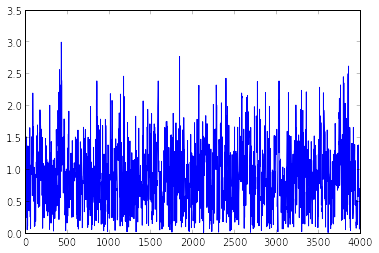

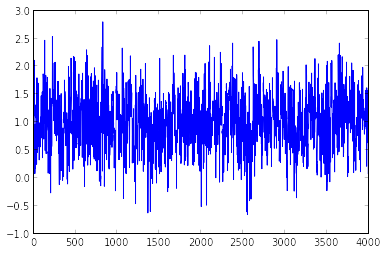

In [260]:
d = nm.sample(4000)
env_d = obspy.signal.filter.envelope(d)

ar_learner = ARLearner(env_d, sf=wave['srate'])
params, std = ar_learner.yulewalker(4)
print params, std, ar_learner.c

em = ErrorModel(0, std)
nm_env = ARModel(params, em, c=ar_learner.c, sf=srate)
ddd = nm_env.sample(4000)

plot(env_d)
figure()
plot(ddd)

# Sample two raw signals with similar wiggles

orig [13, 13, 20, 33]
appending 114 from 60
appending 222 from 114
padded [13, 13, 20, 33, 60, 114]
constructed wavelet basis with 79 params for signal of length 222


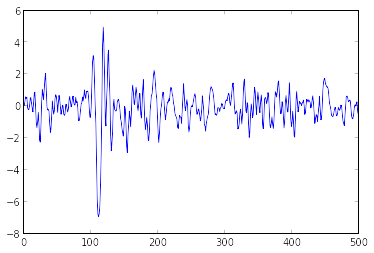

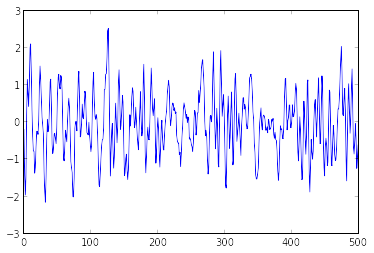

In [261]:
"""
given a set of template params, a wavelet basis and prior on coefs, and a noise model, sample the signal, 
and return the *actual* coefs used?

ultimately we want:
- two raw signals
- method to evaluate wavelet prob for a given atime on a given signal

"""

def construct_tssm(tmvals, srate, nm, cssm, n_cssm, coef_means, coef_vars, envelope=False):
    tmpl = np.exp(LinPolyExpTemplateGenerator.abstract_logenv_raw(tmvals, srate=srate))
    arssm = ARSSM(np.array(nm.params, dtype=np.float), nm.em.std**2, 0.0, nm.c)
    
    atime_idx = int(tmvals['arrival_time']*srate)
    n_repeatable = min(n_cssm, len(tmpl))

    components = [(arssm, 0, 999999, None)]
    if cssm is not None:
        cssm.set_coef_prior(coef_means, coef_vars)
        components.append((cssm, atime_idx, n_repeatable, tmpl))
    if envelope:
        components.append((None, atime_idx, len(tmpl), tmpl))
    
    tssm = TransientCombinedSSM(components, 0.01)
    return tssm

prior_means = np.zeros((n_coefs,))
prior_vars = np.ones((n_coefs))
def sample_doublets(wavelet_family= "db4_6.0_3_10", srate=20.0, amp1=2.0, amp2=1.0):

    basis = construct_wavelet_basis(srate, wavelet_family)
    starray, etarray, idarray, m, n_cssm = construct_implicit_basis_C(srate, wavelet_family)
    n_coefs = len(starray)
    cssm = CompactSupportSSM(starray, etarray, idarray, m, prior_means, prior_vars, 0.0, 0.0)

    tmvals = {'arrival_time': 5.0, 'coda_height': amp1, 'coda_decay': -1.0, 'peak_decay': -1.0, 'peak_offset': -1.0}
    atime_idx = int(tmvals['arrival_time']*srate)
    sampled_coefs = np.array([np.random.randn() for i in range(n_coefs)])
    tssm = construct_tssm(tmvals, srate=srate, nm=nm, cssm=cssm, n_cssm=n_cssm, coef_means=sampled_coefs, coef_vars=np.ones((n_coefs,))*0.01, envelope=False)
    s1 = tssm.prior_sample(500, 0)
    tmvals2 = {'arrival_time': 5.0, 'coda_height': amp2, 'coda_decay': -1.0, 'peak_decay': -1.0, 'peak_offset': -1.0}
    tssm2 = construct_tssm(tmvals2, srate=srate, nm=nm, cssm=cssm, n_cssm=n_cssm, coef_means=sampled_coefs, coef_vars=np.ones((n_coefs,))*0.01, envelope=False)
    s2 = tssm2.prior_sample(500, 1)

    ell, marginals = tssm.all_filtered_cssm_coef_marginals(s1)
    coef_posterior_means, coef_posterior_vars = marginals[1]

    xc_window = s1[atime_idx:atime_idx+100]

    return s1, s2, xc_window, tmvals, tmvals2, cssm, coef_posterior_means, coef_posterior_vars
    
s1, s2, xc_window, tmvals1, tmvals2, cssm, coef_posterior_means, coef_posterior_vars = sample_doublets(amp1=2.0, amp2=0.2)
plot(s1)
figure()
plot(s2)


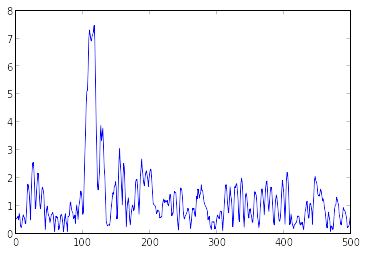

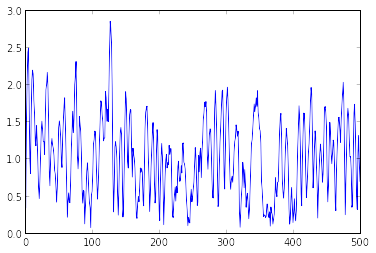

In [262]:
def get_env(s1, s2, tmvals1):

    env1 = obspy.signal.filter.envelope(s1)
    env2 = obspy.signal.filter.envelope(s2)

    tssm = construct_tssm(tmvals1, srate=srate, nm=nm_env, cssm=cssm, n_cssm=n_cssm, 
                          coef_means=prior_means, coef_vars=prior_vars, envelope=True)
    env_ell, env_marginals = tssm.all_filtered_cssm_coef_marginals(env1)
    env_posterior_means, env_posterior_vars = env_marginals[1]

    xc_window_env=env1[atime_idx:atime_idx+100]
    return env1, env2, xc_window_env, env_posterior_means, env_posterior_vars

env1, env2, xc_window_env, env_posterior_means, env_posterior_vars = get_env(s1, s2, tmvals1)
plot(env1)
figure()
plot(env2)

In [263]:
def atime_posterior(s, srate, tmvals, min_t=0, max_t=None, **kwargs):
    
    
    def atime_lp(t):
        t_old = tmvals['arrival_time']
        tmvals['arrival_time'] = t
        tssm = construct_tssm(srate=srate, tmvals=tmvals, **kwargs)
        tmvals['arrival_time'] = t_old
        return tssm.run_filter(s)
    
    max_t = len(s)/float(srate) if max_t is None else max_t
    ts = np.linspace(min_t, max_t, (max_t-min_t)*srate+1)
    lps = [atime_lp(t) for t in ts]
    ps = np.exp(lps-np.max(lps))
    ps /= np.sum(ps)
    return ts, lps, ps

def likelihood_ratio(s, nm, **kwargs):
    tssm = construct_tssm(srate=srate, tmvals=tmvals, nm=nm, **kwargs)
    model_lik = tssm.run_filter(s)
    
    arssm = ARSSM(np.array(nm.params, dtype=np.float), nm.em.std**2, 0.0, nm.c)
    noise_lik = arssm.run_filter(s)
    return model_lik-noise_lik

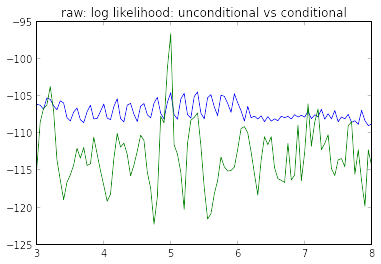

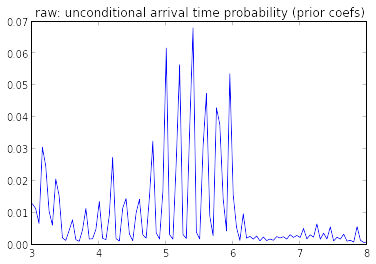

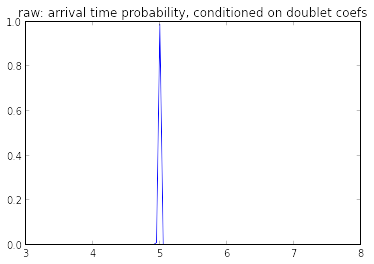

In [264]:
ts, lps_prior, p_prior = atime_posterior(s2, srate, tmvals2, nm=nm, cssm=cssm, n_cssm=n_cssm, 
                                coef_means=prior_means, coef_vars=prior_vars, envelope=False,
                               min_t=3.0, max_t=8.0)
ts, lps_posterior, p_posterior = atime_posterior(s2, srate, tmvals2, nm=nm, cssm=cssm, n_cssm=n_cssm, 
                                    coef_means=coef_posterior_means, coef_vars=coef_posterior_vars+0.01, 
                                    envelope=False, min_t=3.0, max_t=8.0)

plot(ts, lps_prior)
plot(ts, lps_posterior)
title("raw: log likelihood: unconditional vs conditional")
figure()
plot(ts, p_prior)
title("raw: unconditional arrival time probability (prior coefs)")
figure()
plot(ts, p_posterior)
title("raw: arrival time probability, conditioned on doublet coefs")

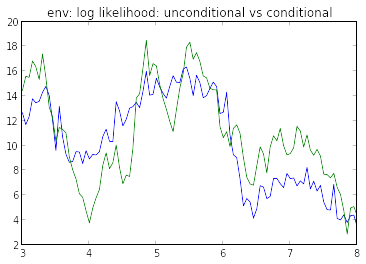

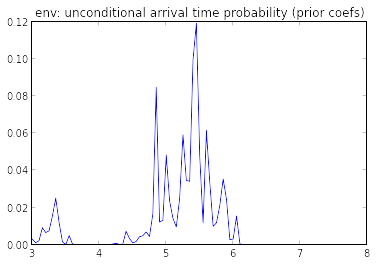

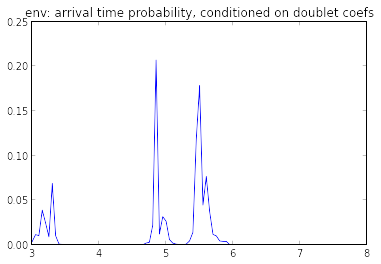

In [265]:
ts, lps_prior, p_prior = atime_posterior(env2, srate, tmvals2, nm=nm_env, cssm=cssm, n_cssm=n_cssm, 
                                coef_means=prior_means, coef_vars=prior_vars, envelope=True,
                               min_t=3.0, max_t=8.0)
ts, lps_posterior, p_posterior = atime_posterior(env2, srate, tmvals2, nm=nm_env, cssm=cssm, n_cssm=n_cssm, 
                                    coef_means=env_posterior_means, coef_vars=env_posterior_vars+0.01, 
                                    envelope=True, min_t=3.0, max_t=8.0)


plot(ts, lps_prior)
plot(ts, lps_posterior)
title("env: log likelihood: unconditional vs conditional")
figure()
plot(ts, p_prior)
title("env: unconditional arrival time probability (prior coefs)")
figure()
plot(ts, p_posterior)
title("env: arrival time probability, conditioned on doublet coefs")



# Cross-correlation

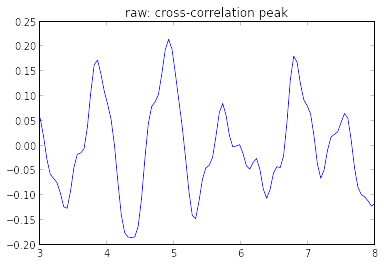

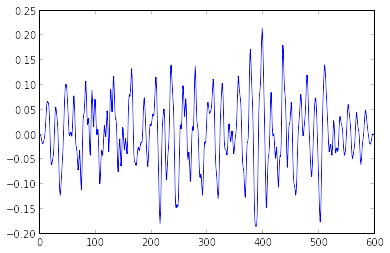

In [266]:
# raw signal
xc = np.correlate(xc_window, s2, mode="full")/np.linalg.norm(xc_window)**2
idxs = 300+np.arange(3*int(srate), 8*int(srate))
ts = np.linspace(3, 8, len(idxs))
figure()
plot(ts, xc[idxs])
title("raw: cross-correlation peak")
figure()
plot(xc)

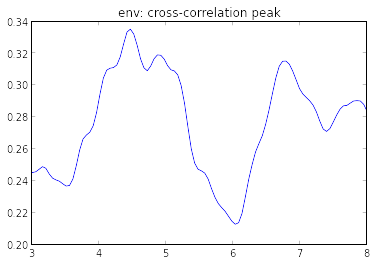

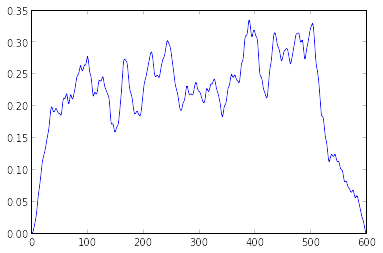

In [267]:
xc = np.correlate(xc_window_env, env2, mode="full")/np.linalg.norm(xc_window_env)**2
idxs = 300+np.arange(3*int(srate), 8*int(srate))
ts = np.linspace(3, 8, len(idxs))
figure()
plot(ts, xc[idxs])
title("env: cross-correlation peak")
figure()
plot(xc)

# Detection sensitivity

## Wavelet model, raw

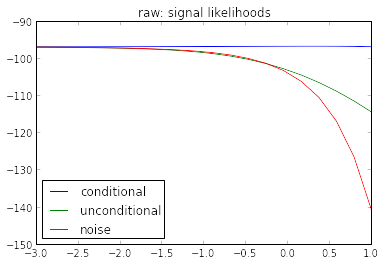

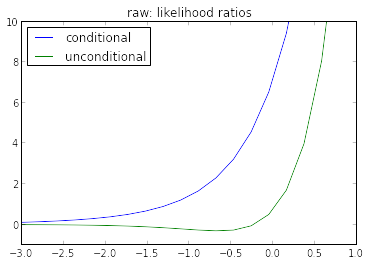

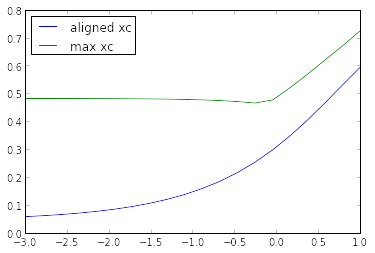

In [268]:
# given a signal, tmvals, and priors on wavelet coefs, compute likelihood ratio under that model.

# where do the signals come from?

def likelihood_ratio(tmvals, envelope, seed=1):
    tssm = construct_tssm(tmvals, srate=srate, nm=nm_env if envelope else nm, cssm=cssm, n_cssm=n_cssm, 
                          coef_means=env_posterior_means if envelope else coef_posterior_means, 
                          coef_vars=env_posterior_vars+0.01 if envelope else coef_posterior_vars+0.01, 
                          envelope=envelope)
    s2 = tssm.prior_sample(500, seed)
    lp1 = tssm.run_filter(s2)
    tssm2 = construct_tssm(tmvals, srate=srate, nm=nm_env if envelope else nm, cssm=cssm, n_cssm=n_cssm, 
                           coef_means=prior_means, coef_vars=prior_vars, envelope=envelope)
    lp2 = tssm2.run_filter(s2)
    
    tmvals['coda_height']=-10.0
    tssm3 = construct_tssm(tmvals, srate=srate, nm=nm_env if envelope else nm, cssm=cssm, n_cssm=n_cssm, 
                           coef_means=prior_means, coef_vars=prior_vars, envelope=envelope)
    lp3 = tssm3.run_filter(s2)
    
    xcw = xc_window_env if envelope else xc_window
    xc = np.correlate(xcw, s2, mode="full")/(np.linalg.norm(xcw)*np.linalg.norm(s2[100:100+len(xcw)]))
    #figure()
    #plot(xc[300:500])
    #figure()
    #plot(s2)
    return lp1, lp2, lp3, xc[400], np.max(xc)

l1 = []
l2 = []
l3 = []
xcs = []
xcmax= []
amps = np.linspace(-3.0, 1.0, 20)
#tmvals['coda_height']=-1.0
#lp1, lp2, lp3 = likelihood_ratio(tmvals, envelope=False, seed=1)
tmvals['arrival_time']=5.0
for amp2 in amps:
    tmvals['coda_height']=amp2
    lp1, lp2, lp3, xcp, xcm = likelihood_ratio(tmvals, envelope=False, seed=1)
    l1.append(lp1)
    l2.append(lp2)
    l3.append(lp3)
    xcs.append(xcp)
    xcmax.append(xcm)
l1, l2, l3, xcs, xcmax = np.array(l1), np.array(l2), np.array(l3), np.array(xcs), np.array(xcmax)

figure()
plot(amps, l1, label="conditional")
plot(amps, l2, label="unconditional")
plot(amps, l3, label="noise")
legend(loc="best")
title('raw: signal likelihoods')
figure()
plot(amps, l1-l3, label="conditional")
plot(amps, l2-l3, label="unconditional")
gca().set_ylim((-1, 10.0))
legend(loc="best")
title("raw: likelihood ratios")
figure()
plot(amps, xcs, label="aligned xc")
plot(amps, xcmax, label="max xc")
legend(loc="best")

## Wavelet model, env

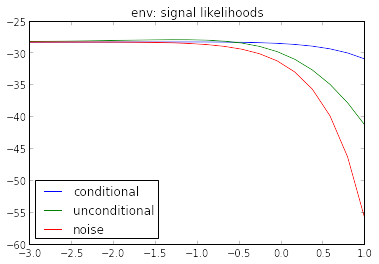

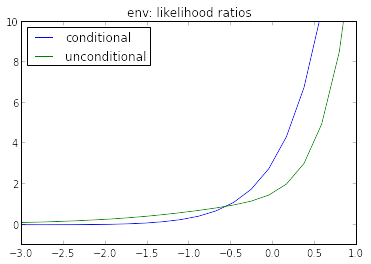

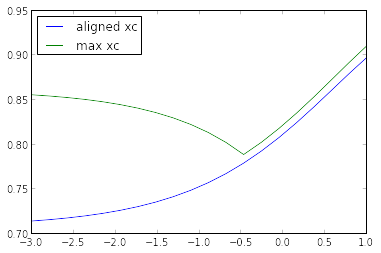

In [269]:

l1 = []
l2 = []
l3 = []
xcs = []
xcmax= []
amps = np.linspace(-3.0, 1.0, 20)
#tmvals['coda_height']=-1.0
#lp1, lp2, lp3 = likelihood_ratio(tmvals, envelope=False, seed=1)

tmvals['arrival_time']=5.0
for amp2 in amps:
    tmvals['coda_height']=amp2
    lp1, lp2, lp3, xcp, xcm = likelihood_ratio(tmvals, envelope=True, seed=1)
    l1.append(lp1)
    l2.append(lp2)
    l3.append(lp3)
    xcs.append(xcp)
    xcmax.append(xcm)
l1, l2, l3, xcs, xcmax = np.array(l1), np.array(l2), np.array(l3), np.array(xcs), np.array(xcmax)

plot(amps, l1, label="conditional")
plot(amps, l2, label="unconditional")
plot(amps, l3, label="noise")
legend(loc="best")
title('env: signal likelihoods')
figure()
plot(amps, l1-l3, label="conditional")
plot(amps, l2-l3, label="unconditional")
legend(loc="best")
gca().set_ylim((-1, 10.0))
title("env: likelihood ratios")
figure()
plot(amps, xcs, label="aligned xc")
plot(amps, xcmax, label="max xc")
legend(loc="best")

In [223]:
len(s2)

500

In [255]:
print tmvals


{'coda_height': -10.0, 'arrival_time': 10.0, 'coda_decay': -1.0, 'peak_decay': -1.0, 'peak_offset': -1.0}
